In [1]:
using Random
using Distributions
using Plots

Random.seed!(1234);
rng = MersenneTwister(1234);
gr();

In [2]:
include("../feature/feature.jl");
include("../linear/linear.jl");

In [3]:
function create_toy_data(func, sample_size, std, domain=[0., 1.])
    x = collect(reshape(range(domain[1], stop=domain[2], length=sample_size),sample_size));
    shuffle!(rng, x);
    noise = rand(Normal(0.0, std), sample_size);
    return x, func(x) + noise
end

function sinusoidal(x)
    return sin.(2 * pi * x)
end

sinusoidal (generic function with 1 method)

## Polynomial, Gaussian, Sigmoid features

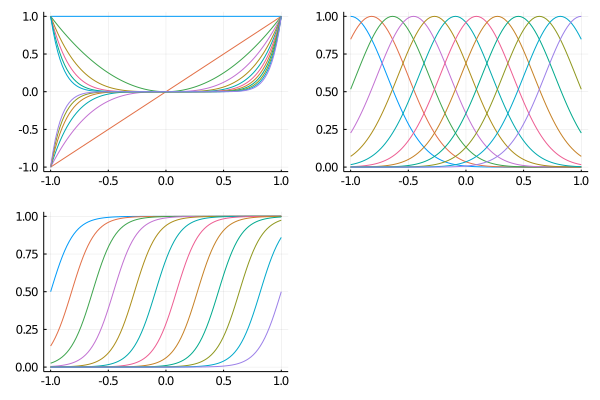

In [4]:
x = collect(reshape(range(-1.0, stop=1.0, length=100), 100));
means = collect(reshape(range(-1.0, stop=1.0, length=12), 12));
feature_poly = PolynomialFeature(11);
feature_gauss = GaussianFeature(means, 0.1);
feature_sigmoid = SigmoidalFeature(means, 10.0);

X_polynomial = transform(feature_poly, x);
X_gaussian = transform(feature_gauss, x);
X_sigmoidal = transform(feature_sigmoid, x);

plots = [];
# polynomial
p = plot();
for j in 1:12
    p = plot!(x, X_polynomial[j, :]);
end
push!(plots, p);
# gaussian
p = plot();
for j in 1:12
    p = plot!(x, X_gaussian[j, :]);
end
push!(plots, p);
# sigmoidal
p = plot();
for j in 1:12
    p = plot!(x, X_sigmoidal[j, :]);
end
push!(plots, p);

plot(plots[1], plots[2], plots[3], legend=nothing)

## Ridge regression

$$
\boldsymbol{w} = (\boldsymbol{\Phi}^{T} \boldsymbol{\Phi} + \lambda I)^{-1} \boldsymbol{\Phi}^{T} \boldsymbol{t}
$$


In [5]:
x_train, y_train = create_toy_data(sinusoidal, 10, 0.4);
x_test = collect(reshape(range(0, stop=1.0, length=100), 100));
y_test = sinusoidal(x_test);

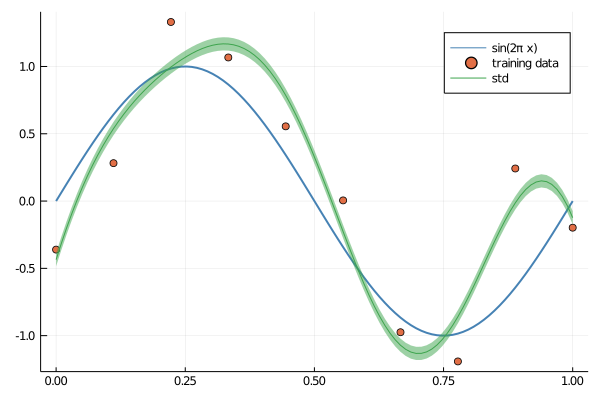

In [6]:
means = collect(reshape(range(0, stop=1.0, length=7), 7));
feature = GaussianFeature(means, 0.1);

X_train = transform(feature, x_train);
X_test = transform(feature, x_test);
model = LinearRegressor([0], 0);
fitting(model, X_train, y_train);

y, var = predict(model, X_test, true);
y_std = fill(var, size(y)[1]);

plot(x_test, y_test, label="sin(2π x)", color="steelblue", lw=2);
plot!(x_train, y_train, label="training data", seriestype=:scatter);
plot!(x_test, y, ribbon=(y_std, y_std), fillalpha=0.5, label="std")

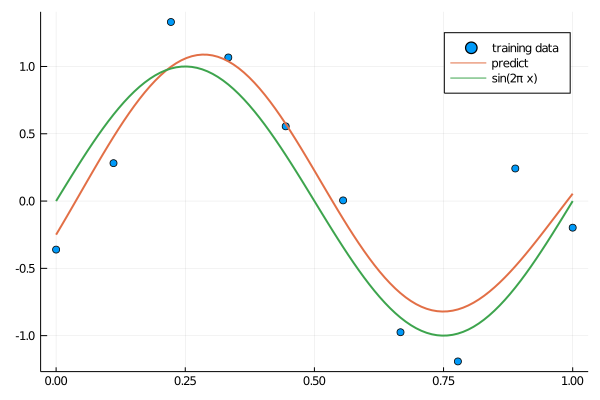

In [7]:
model = RidgeRegressor([0.0], 1e-2);
fitting(model, X_train, y_train);
y = predict(model, X_test);

plot(x_train, y_train, label="training data", seriestype=:scatter);
plot!(x_test, y, label="predict", lw=2)
plot!(x_test, y_test, label="sin(2π x)", lw=2)

## Bias-Variance decomposition

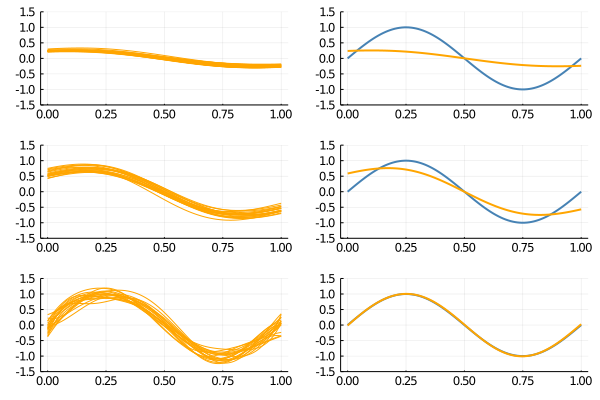

In [8]:
means = collect(reshape(range(0, stop=1.0, length=24), 24));
feature = GaussianFeature(means, 0.1);

plots = [];
for a in [1e2, 1.0, 1e-9]
    y_list = [];
    p = plot();
    for i in 1:100
        x_train, y_train = create_toy_data(sinusoidal, 25, 0.25);
        x_test = collect(reshape(range(0, stop=1.0, length=100), 100));
        X_train = transform(feature, x_train);
        X_test = transform(feature, x_test);
        model = BayesianRegressor(a, 1.0, 24);
        fitting(model, X_train, y_train);
        y = predict(model, X_test);
        push!(y_list, y);
        if i < 20
            p = plot!(x_test, y, color="orange");
        end
    end
    
    push!(plots, p);
    p = plot();
    p = plot!(x_test, y_test, color="steelblue", lw=2);
    p = plot!(x_test, mean(y_list), color="orange", lw=2);
    push!(plots, p);
end

plot(plots[1], plots[2], plots[3], plots[4], plots[5], plots[6], layout=(3, 2), ylim=(-1.5, 1.5), legend=nothing)

## Bayesian learning

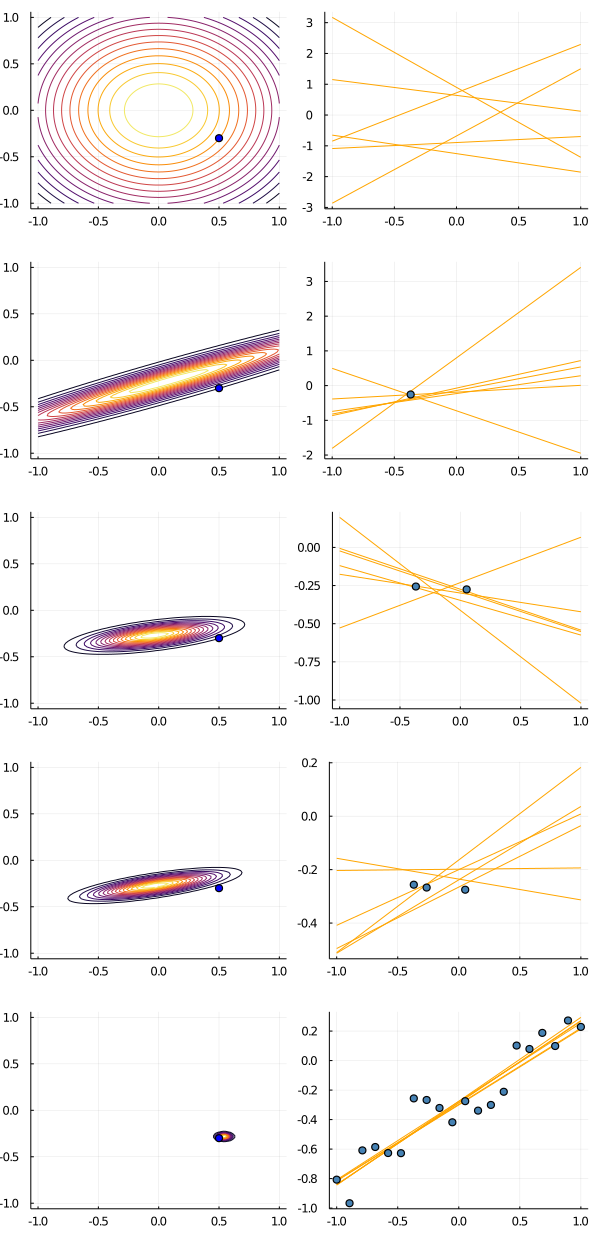

In [9]:
function linear(x)
    return -0.3 .+ 0.5 .* x
end

x_train, y_train = create_toy_data(linear, 20, 0.1, [-1., 1.]);
x = collect(reshape(range(-1., stop=1., length=100), 100));
y = collect(reshape(range(-1., stop=1., length=100), 100));
#grids = [[i, j] for i in x, j in y];

model = BayesianRegressor(1.0, 100.0, 2);
feature = PolynomialFeature(1);
X_train = transform(feature, x_train);
X = transform(feature, x);

dist = MvNormal(model._w_mean, inv(model._w_precision));
vals = [pdf(dist, [i, j]) for i in x, j in y];

plots = [];
p = contour(x, y, vals, colorbar=false);
p = plot!([0.5], [-0.3], seriestype=:scatter, marker=:dot, markersize=:4, markercolor="blue");
push!(plots, p);

Y_random = predictSampling(model, X, 6);
p = plot();
for i in 1:6
    p = plot!(x, Y_random[i, :], c="orange");
end
push!(plots, p);

for (index, values) in enumerate([[1, 1], [2, 2], [3, 3], [4, 20]])
    first = values[1];
    last = values[2];
    fitting(model, X_train[:, first:last], y_train[first:last]);
    dist = MvNormal(model._w_mean, inv(model._w_precision));
    vals = [pdf(dist, [i, j]) for i in x, j in y];
    p = contour(x, y, vals, colorbar=false);
    p = plot!([0.5], [-0.3], seriestype=:scatter, marker=:dot, markersize=:4, markercolor="blue");
    push!(plots, p);

    Y_random = predictSampling(model, X, 6);
    p = plot();
    for i in 1:6
        p = plot!(x, Y_random[i, :], c="orange");
    end
    p = plot!(x_train[1:last], y_train[1:last], c="steelblue", seriestype=:scatter);
    push!(plots, p);
end

plot(plots[1], plots[2], plots[3], plots[4], plots[5], plots[6], plots[7], plots[8], plots[9], plots[10], layout=(5, 2), size=(600, 1250), legend=nothing)

## Bayesian linear regression

### Regression

The data is generated from the distribution

$$
\begin{align} t = y(\boldsymbol{x}, \boldsymbol{w}) + \epsilon \end{align}.
$$

Or

$$
\begin{align} p(t \mid \boldsymbol{w}, \beta) = \mathcal{N}(t \mid y(\boldsymbol{x}, \boldsymbol{w}), \beta^{-1}) \end{align}
$$

And the training data is denoted as $\boldsymbol{X} = [\boldsymbol{x}_1, \cdots \boldsymbol{x}_N]$, and $\boldsymbol{t} = [t_1, \cdots t_N]$. The likelihood for the traning data is then given by

$$
\begin{align} p(\boldsymbol{t} \mid \boldsymbol{X}, \boldsymbol{w}, \beta) = \prod \mathcal{N}(t_n \mid \boldsymbol{w}^{\text{T}} \boldsymbol{\phi}(\boldsymbol{x}_n), \beta^{-1}) \end{align}
$$

Now we assume the prior distribution for $\boldsymbol{w}$ is $\mathcal{N}(\boldsymbol{w} \mid \boldsymbol{m}_0, S_0)$. Then the Bayes's theorem gives the posterior distribution for $\boldsymbol{w}$ as follows,

$$
\begin{align} p(\boldsymbol{w} \mid \boldsymbol{t}_N) &= \mathcal{N}(\boldsymbol{m}_N, S_N) \\ \boldsymbol{m}_N &= S_N(S_0^{-1} \boldsymbol{m}_0 + \beta \Phi_N^{\text{T}}\boldsymbol{t}_N) \\ S_N^{-1} &= S_0^{-1} + \beta \Phi_N^{\text{T}}\Phi_N \end{align}
$$

where

$$
\Phi_{N}^{\text{T}} = \begin{bmatrix} \boldsymbol{\phi}_{1} & \boldsymbol{\phi}_{2} & \cdots & \boldsymbol{\phi}_{N} \end{bmatrix}, \quad
\Phi_N = \begin{bmatrix} \boldsymbol{\phi}_{1}^{\text{T}} \\ \boldsymbol{\phi}_{2}^{\text{T}} \\ \vdots \\ \boldsymbol{\phi}_{N}^{\text{T}} \end{bmatrix}
$$

### Predictive distribution

$$
p(t \mid \boldsymbol{x}, \alpha, \beta) = \mathcal{N} \left(t \mid\boldsymbol{m}_{N}^{\text{T}}\phi(\boldsymbol{x}), \sigma^2(\boldsymbol{x}) \right)
$$

where

$$
\sigma^2(\boldsymbol{x}) = \dfrac{1}{\beta} + \phi(\boldsymbol{x})^{\text{T}} S_N \phi(\boldsymbol{x})
$$

As you can see, the variance is dependent on $\boldsymbol{x}$.

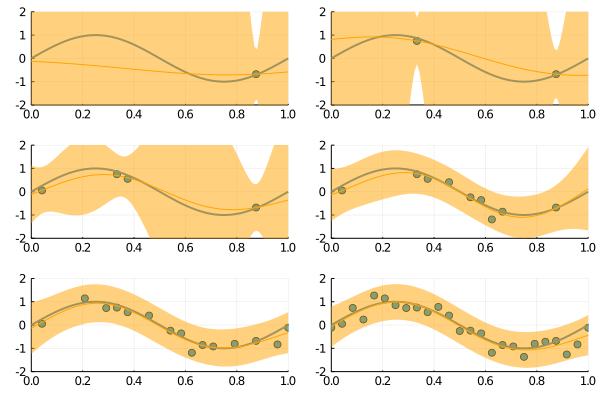

In [10]:
x_train, y_train = create_toy_data(sinusoidal, 25, 0.25);
x_test = collect(reshape(range(0, stop=1.0, length=100), 100));
y_test = sinusoidal(x_test);

means = collect(reshape(range(0, stop=1.0, length=9), 9));
feature = GaussianFeature(means, 0.1);
X_train = transform(feature, x_train);
X_test = transform(feature, x_test);

model = BayesianRegressor(1e-3, 2.0, 9);
plots = [];

for (index, ranges) in enumerate([[1, 1], [2, 2], [3, 4], [5, 9], [10, 15], [16, 25]])
    first, last = ranges[1], ranges[2];
    fitting(model, X_train[:, first:last], y_train[first:last]);
    y, y_std = predict(model, X_test, true);
    p = plot(x_train[1:last], y_train[1:last], seriestype=:scatter);
    p = plot!(x_test, y_test, lw=2, color="steelblue");
    p = plot!(x_test, y, ribbon=(y_std, y_std), fillalpha=0.5, color="orange");
    push!(plots, p);
end

l = @layout [a b; c d; e f];

plot(plots[1], plots[2], plots[3], plots[4], plots[5], plots[6], xlim=(0, 1), ylim=(-2, 2), layout=l, legend=nothing)